# Baysian Predictive Synthesis

## abstract

 Spatial data are characterized by their spatial dependence, which is often complex, non-linear, and difficult to capture with a single model. Significant levels of model uncertainty -- arising from these characteristics -- cannot be resolved by model selection or simple ensemble methods. We address this issue by proposing a novel methodology that captures spatially varying model uncertainty, which we call Bayesian spatial predictive synthesis. Our proposal is derived by identifying the theoretically best approximate model under reasonable conditions, which is a latent factor spatially varying coefficient model in the Bayesian predictive synthesis framework. We then show that our proposed method produces exact minimax predictive distributions, providing finite sample guarantees. Two MCMC strategies are implemented for full uncertainty quantification, as well as a variational inference strategy for fast point inference. We also extend the estimation strategy for general responses. Through simulation examples and two real data applications, we demonstrate that our proposed spatial Bayesian predictive synthesis outperforms standard spatial models and advanced machine learning methods in terms of predictive accuracy.

## Ref

- [http://arxiv.org/abs/2203.05197](http://arxiv.org/abs/2203.05197)

In [113]:
import numpy as np
from numpy.random import default_rng
from copy import copy

# visualize
import arviz
import matplotlib.pyplot as plt

# cmdstanpy
from cmdstanpy import CmdStanModel

# random generator
rg = default_rng(123)

## Method

$$
y_i = \beta_{0i} + \sum_{j = 1}^{J} \beta_{ji}f_{ij} + \epsilon_{i} \quad \epsilon_i \sim N(0, \sigma^2)
$$

$$
\boldsymbol{\beta}_j  = (\beta_{j1}, \ldots \beta_{jn})^T \sim N(0, \tau_j G(g_j))
$$

In [114]:
# data settings
N = 1000
J = 5

# parameters
tau = [0.1, 0.2, 0.3, 0.4, 0.5]
sigma = 2.0
all_beta = np.array([rg.multivariate_normal(np.zeros(N), tau[j] * np.eye(N)) for j in range(J)]).T

f_matrix = rg.normal(size=(N, J))
Y = (all_beta * f_matrix).sum(axis = 1) + rg.normal(loc = 0, scale= sigma, size=N)

In [115]:
# モデル読み込み
model = CmdStanModel(stan_file="../../src/stan/BaysianPredictSynthesis.stan")

# モデル式
print("-------------------")
model.format()

11:04:03 - cmdstanpy - INFO - compiling stan file /home/akihiro/project/note/src/stan/BaysianPredictSynthesis.stan to exe file /home/akihiro/project/note/src/stan/BaysianPredictSynthesis
11:04:13 - cmdstanpy - INFO - compiled model executable: /home/akihiro/project/note/src/stan/BaysianPredictSynthesis


-------------------
data {
  // num of data
  int<lower=0> N;
  int<lower=0> J;
  
  // observation data
  vector[N] y_obs;
  matrix[N, J] f_matrix;
}
parameters {
  matrix[N, J] beta;
  real<lower=0> sigma;
  vector<lower=0>[J] tau;
}
model {
  y_obs ~ normal(sum(beta .* f_matrix), sigma);
}




In [116]:
# Data dict for stan
stan_data = {
    "N": N,
    "J": J,
    "y_obs": Y,
    "f_matrix" : f_matrix
}

# 計算
res = model.sample(
    data=stan_data,
    iter_warmup=1500,
    iter_sampling=500,
    parallel_chains=4,
    chains=4,
)

11:04:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:04:37 - cmdstanpy - INFO - CmdStan done processing.


11:04:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 500 divergent transitions (100.0%)
	Chain 2 had 500 divergent transitions (100.0%)
	Chain 3 had 500 divergent transitions (100.0%)
	Chain 4 had 500 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


/home/akihiro/miniconda3/envs/pystan/lib/python3.9/site-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/akihiro/miniconda3/envs/pystan/lib/python3.9/site-packages/arviz/stats/density_utils.py:706: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
/home/akihiro/miniconda3/envs/pystan/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/akihiro/miniconda3/envs/pystan/lib/python3.9/site-packages/numpy/core/function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start
/home/akihiro/miniconda3/envs/pystan/lib/python3.9/site-packages/matplotlib/axes/_base.py:2917: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

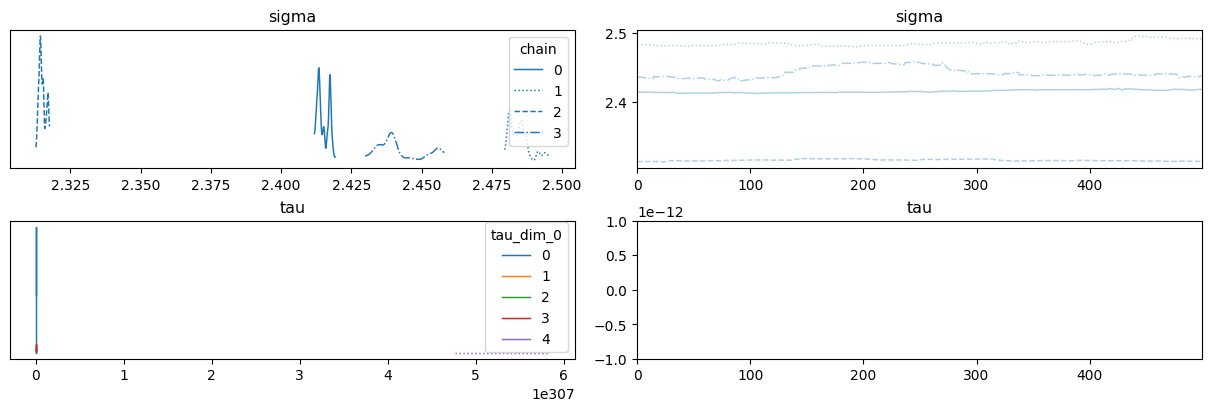

In [117]:
arviz.plot_trace(
    res, 
    var_names=["~beta"],
    legend = True, 
    divergences=None,
    backend_kwargs={"constrained_layout": True},
    )